# Double DQN From Scratch

The max operator in standard Q-Learning and DQN uses the same values to select and evaluate actions. This makes the value function likely to overestimate values, resulting in overoptimistic estimates.

The idea of Double Q-Learning is to reduce the overestimations by decomposing the max operation in the TD target into action selection and action evaluation.

# Imports & Constants

In [2]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [3]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import highway_env
import time

import pandas as pd

from typing import Dict
from torch._tensor import Tensor
from IPython.display import clear_output

from agents import MlpDQNAgent

# Double DQN

In [4]:
class MlpDDQNAgent(MlpDQNAgent):
    """
    Class representing a Double DQN agent utilising MLP Feed-Forward Neural Networks.
    """

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> Tensor:
        """
        Computes and returns the Double DQN loss.
        """
        device = self.device

        # Shape = (batch_size, obs dim 1, obs dim 2, ...)
        # This flattens the observation dimensions of `state` and `next_state`.
        state = torch.FloatTensor(samples["obs"].reshape(self.batch_size, -1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"].reshape(self.batch_size, -1)).to(device)

        # Reshapes each 1-dimesional array into a 2-dimensional array with one column.
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)

        # This line is what makes the agent a Double DQN agent.
        next_q_value = self.dqn_target(next_state).gather( 
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        
        mask = 1 - done
        # Calculate the TD target
        target = (reward + self.gamma * next_q_value * mask).to(device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

# Train an agent

In [5]:
config = {
    'lanes_count': 4,
    'duration': 50,
}

In [6]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [7]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = MlpDDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed = seed,
    gamma = gamma
)

cuda


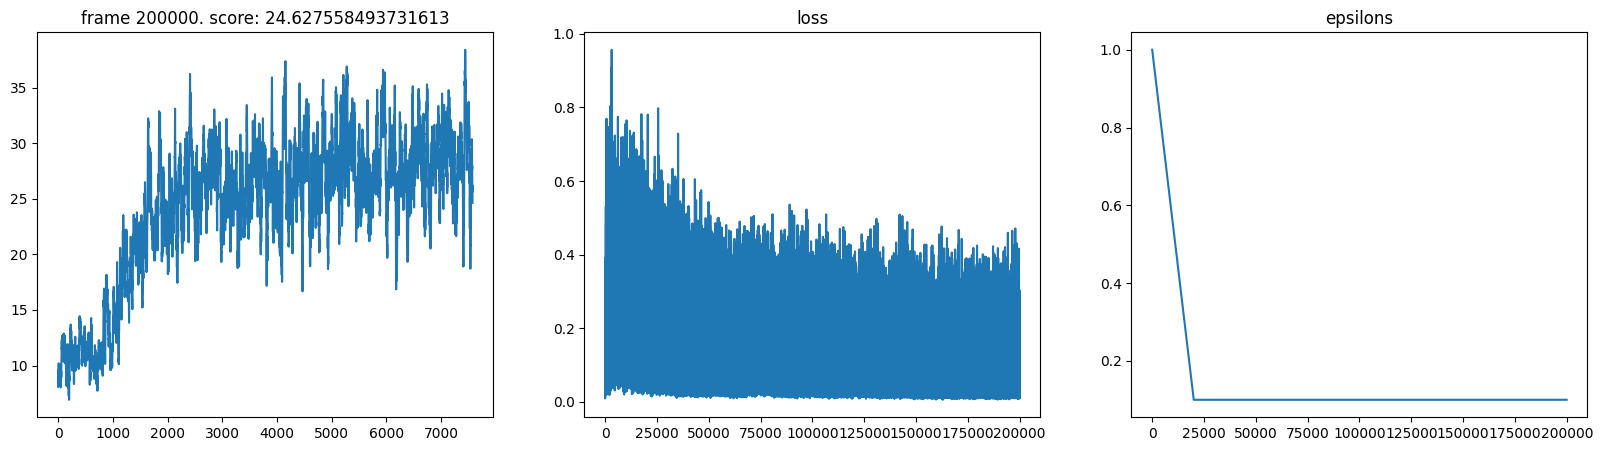

In [8]:
scores, losses, epsilons = agent.train(num_frames)

In [14]:
pd.DataFrame({"Double DQN": scores}).to_csv("../results/double_dqn.csv")

# Test the agent

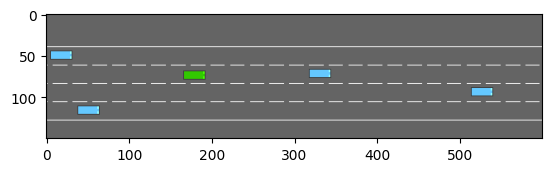

In [9]:
ep_lens, ep_rews = agent.test(5, time_interval=0.1)

In [10]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 50.0
Mean Score Per Episode: 46.43633081064939
